In [1]:
from six.moves import xrange
import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm

from model import VQVAE, _mnist_arch

DATA_DIR = 'datasets/mnist'
MODEL,K,D = \
    ('models/mnist/last.ckpt',
     20,
     64)
# <<<<<<<

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

# >>>>>>> MODEL
with tf.variable_scope('net'):
    with tf.variable_scope('params') as params:
        pass
    x = tf.placeholder(tf.float32,[None,784])
    resized = tf.image.resize_images(
        tf.reshape(x,[-1,28,28,1]),
        (24,24),
        method=tf.image.ResizeMethod.BILINEAR)

    net = VQVAE(None,None,0.25,resized,K,D,_mnist_arch,params,False)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.graph.finalize()
sess.run(init_op)
net.load(sess,MODEL)

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord,sess=sess)

def draw(images):
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(10,10))
    for n, image in enumerate(images):
        a = fig.add_subplot(10, 10, n + 1)
        a.imshow( np.squeeze((image*255.0)).astype(np.uint8), cmap='gray' )
        a.axis('off')
        a.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


Extracting datasets/mnist/train-images-idx3-ubyte.gz
Extracting datasets/mnist/train-labels-idx1-ubyte.gz
Extracting datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting datasets/mnist/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from models/mnist/last.ckpt


## MNIST Reconstruction - Test set

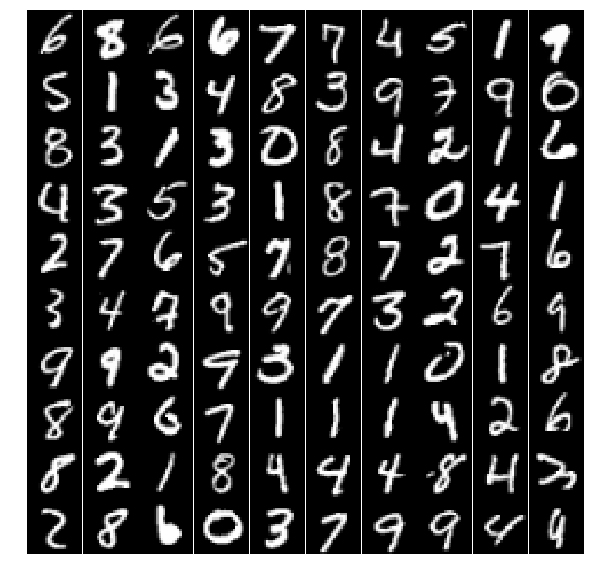

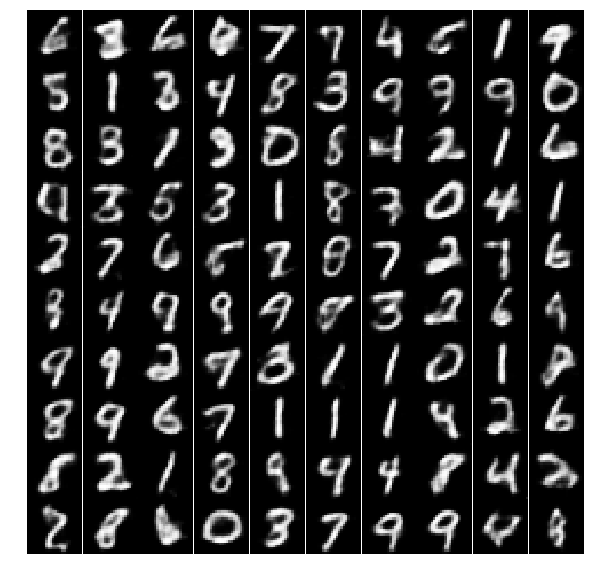

In [2]:
ims, _= mnist.test.next_batch(100)
valid_origin, valid_recons = sess.run([resized,net.p_x_z],feed_dict={x:ims})
draw(valid_origin)
draw(valid_recons)## MNIST Reconstruction - Test set

## MNIST Reconstruction - Training set

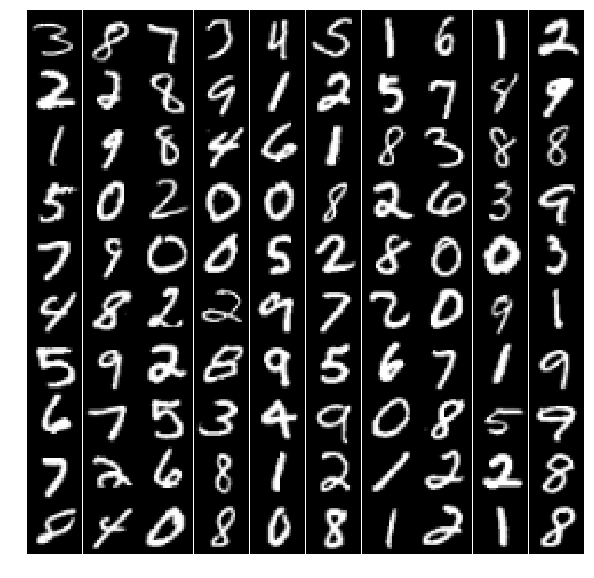

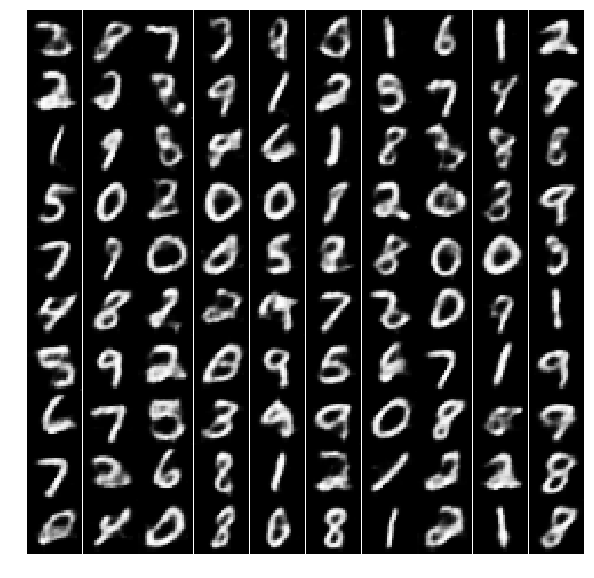

In [3]:
ims, _= mnist.train.next_batch(100)
origin, recons = sess.run([resized,net.p_x_z],feed_dict={x:ims})
draw(origin)
draw(recons)## MNIST Reconstruction - Test set

## Latent Space Observation

In [3]:
from tqdm import tqdm

ims, labels = mnist.train.next_batch(50000)

latent_orig_recons = []
for im,label in tqdm(zip(ims,labels)):
    latent_orig_recons.append(sess.run([net.k,resized,net.p_x_z],feed_dict={x:im[None]}))
latents, origs, recons = list(zip(*latent_orig_recons))
latents = np.stack(latents,axis=0)

# num = len(latents)
# dist = np.ones((num,num),np.int32) * 10
# for i,latent_i in enumerate(tqdm(latents)):
#     for j,latent_j in enumerate(latents):
#         if( j >= i ):
#             continue
#         dist[i,j] = np.count_nonzero( latent_i != latent_j )

50000it [01:01, 813.77it/s]


### How many unique vectors exist from dataset?

In [6]:
u, indices = np.unique(latents, axis=0, return_index=True)
len(u)

45697

### Can any meaningful discretization be found?

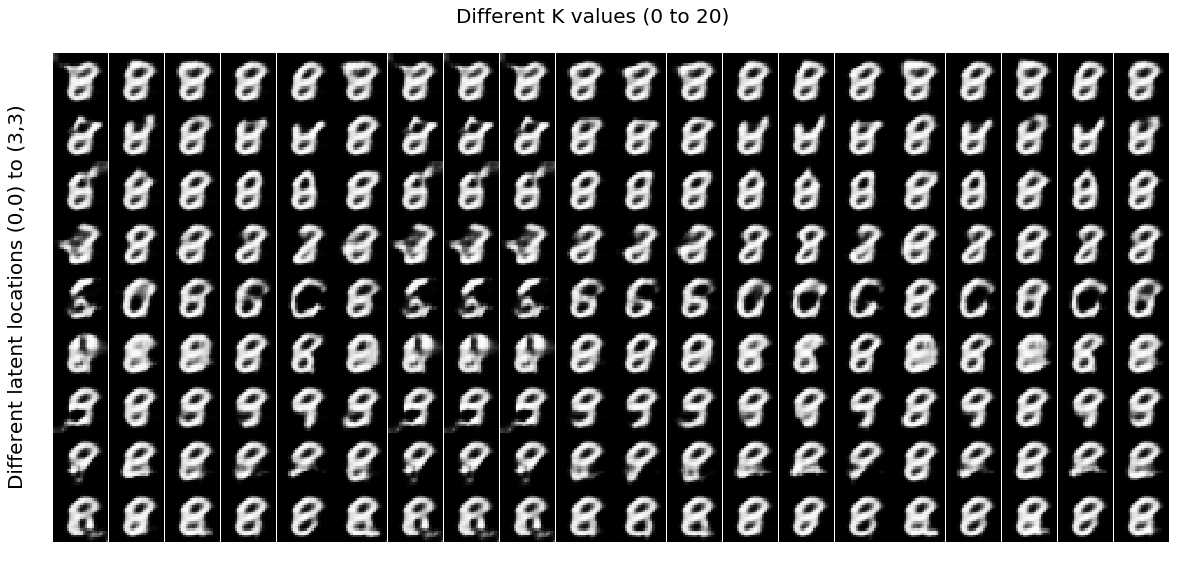

In [25]:
def draw(images):
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(20,9))
    fig.text(0.5,0.95,'Different K values (0 to 20)',horizontalalignment='center',
           verticalalignment='top',fontsize=20)
    fig.text(0.1,0.80,'Different latent locations (0,0) to (3,3)',horizontalalignment='center',
           verticalalignment='top',rotation='vertical',fontsize=20)
    for n, image in enumerate(images):
        a = fig.add_subplot(9, 20, n + 1)
        a.imshow( np.squeeze((image*255.0)).astype(np.uint8), cmap='gray' )
        a.axis('off')
        a.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()
    
latent = np.squeeze(latents[np.random.choice(len(latents))])
images = []
for i in range(3):
    for j in range(3):
        real_k = latent[i,j]
        for k in range(K):
            latent[i,j]=k
            images.append(sess.run([net.gen],feed_dict={net.latent:latent[None]})[0])
        latent[i,j] = real_k
draw(images)

### Random Walk on Latent Space

In [15]:
def display_frames_as_gif(frames):
    from matplotlib import pyplot as plt
    from matplotlib import animation, rc
    from IPython.core.display import display, HTML

    fig, ax = plt.subplots()
    fig.tight_layout()
    patch = ax.imshow(np.squeeze((frames[0]*255.0)).astype(np.uint8),cmap='gray')
    ax.axis('off')
    ax.set_aspect('equal')
    def animate(i):
        patch.set_data(np.squeeze((frames[i]*255.0)).astype(np.uint8))
    
    anim = animation.FuncAnimation(fig, animate, range(len(frames)), interval=50)
    display(HTML(anim.to_html5_video()))
    plt.close()
    
latent = np.squeeze(latents[np.random.choice(len(latents))])
images = []
for _ in tqdm(range(1000)):
    i,j = np.random.choice(3),np.random.choice(3)
    latent[i,j] = (latent[i,j] + np.random.choice([-1,1])) % K
    images.append(sess.run(net.gen,feed_dict={net.latent:latent[None]})[0])
display_frames_as_gif(images)

100%|██████████| 1000/1000 [00:00<00:00, 2048.37it/s]
